## Сентимент-анализ отзывов (простая версия)

В этом соревновании вам предстоит прогнозировать по тексту отзыва его тональность: 1 - позитивная, 0 - негативная. В отличие от усложненной версии задачи, здесь вам не требуется самостоятельно собирать обучающую выборку - она есть в предоставляемых вам данных.

#### Возьмем бейзлайн и попробуем улучшить его скор за счет тюнинга.

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
train = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None, names = ['text', 'y'])
test = pd.read_csv('products_sentiment_test.tsv', sep='\t')

In [3]:
# Создадим вспомогательных аналайзер на основе стеммера Портера


def stemmed(text):
    stemmer = PorterStemmer()
    analyzer = TfidfVectorizer().build_analyzer()
    return (stemmer.stem(word) for word in analyzer(preprocess(text)))

# Заменим 't на not
def preprocess(text):
    return text.replace(" 't", " not")

train['x'] = train.text.apply(preprocess)
test['x'] = test.text.apply(preprocess)

In [4]:
# Объединим векторизованные фичи разных типов токенов
union = FeatureUnion([("word11", TfidfVectorizer(ngram_range=(1,1), smooth_idf=False, analyzer='word')),
                      ("stem11", TfidfVectorizer(ngram_range=(1,1), smooth_idf=False, analyzer=stemmed)),
                      ("word23", TfidfVectorizer(ngram_range=(2,3), smooth_idf=False, analyzer='word')),
                      ("stem23", TfidfVectorizer(ngram_range=(2,3), smooth_idf=False, analyzer=stemmed)),
                      ("char14", TfidfVectorizer(ngram_range=(1,4), smooth_idf=False, analyzer='char')),
                      ("char15", TfidfVectorizer(ngram_range=(1,5), smooth_idf=False, analyzer='char'))])


# Объединим в Pipeline с линейной регрессией в качестве классификатора
pipe = Pipeline([("vectorizer", union),
                # ("reduce_dim", TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5)),
                 ("classifier", LogisticRegression(penalty = 'l2'))])

# Расчитаем точность по кроссвалидации
scores = cross_val_score(pipe, train.x, train.y, cv = 5, scoring='accuracy')
print(scores.mean()) # 0.794 --> 0.7955

0.7955


#### За счет добавления некоторых ngram и доп. параметров TfidfVectorizer на трейне получилось увеличение скора 0.794 --> 0.7955. 

#### Другие эксперименты не дали прироста, поэтому в текущее решение не включены.

Обучим подобранный пайплайн на трейне и сформируем файл с предсказаниями для теста:

In [8]:
pipe.fit(train.x, train.y)
test['y'] = pipe.predict(test.x)

test[['Id','y']].to_csv('product-reviews-sentiment-analysis-light.csv', index = False)

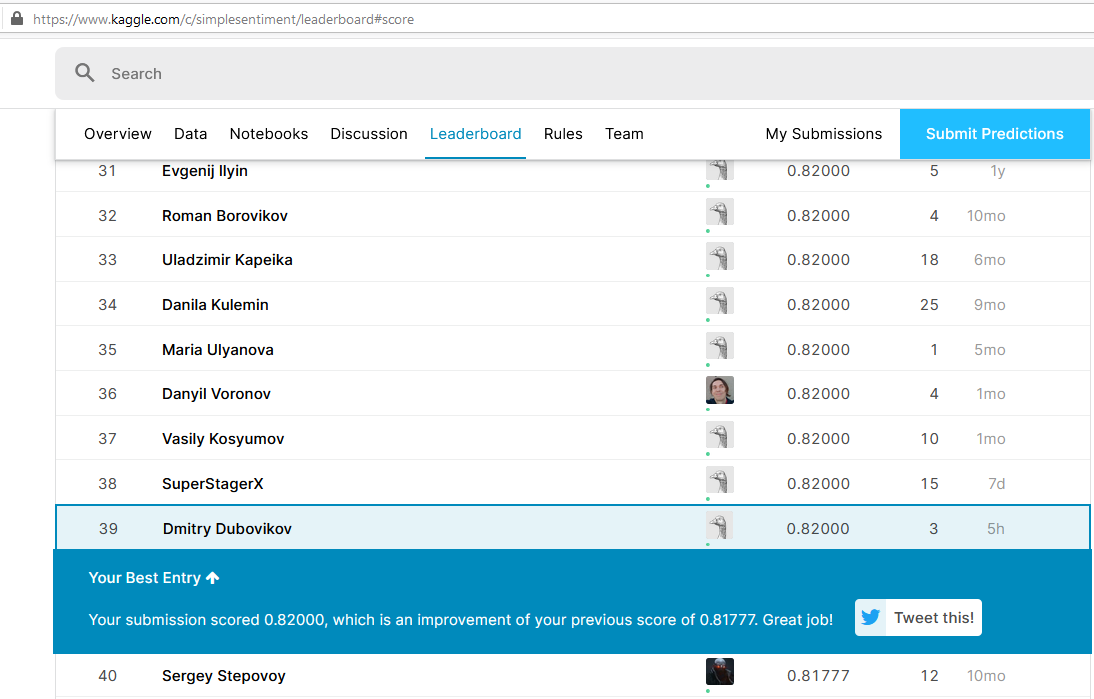